In [1]:
class Dataset():
    def __init__(self, **kwargs):
        pass
    
    def getData(self, idx):
        pass

In [2]:
from utils import *
from tools import *

class DynamicSimulatedDataset(Dataset):
    def __init__(self, **kwargs):
        x0 = kwargs.pop('x0', (0,0))
        v0 = kwargs.pop('v0', 5)
        a0 = kwargs.pop('a0', 0)
        N = kwargs.pop('N', 150)
        prior = kwargs.pop('prior', (1, 0.009, -0.004))
        dR = kwargs.pop('dR', 0.4)
        dAz = kwargs.pop('dAz', 0.05)
        polynom_noise_ratio = kwargs.pop('polynom_noise_ratio', 0.5)
        seed = kwargs.pop('seed', None)
        self.__generateEgoMotion(x0=np.asarray(x0), v0=v0, a0=a0, path=prior, N=N, dT=0.1)
        self.prior, self.dR, self.dAz, self.polynom_noise_ratio = prior, dR, dAz, polynom_noise_ratio
        x, y = createPolynom(a1=prior[0],a2=prior[1],a3=prior[2],xstart=0,xend=200)
        self.N = N
        
    def getData(self, t):
        pos = [self.t[0,t], self.t[1,t]]
        heading = np.rad2deg(np.arccos(self.R[0,0,t]))
        z,dz = self.__generateData(prior=self.prior, dR=self.dR, dAz=self.dAz, pos=pos, R=self.R[:,:,t], polynom_noise_ratio=self.polynom_noise_ratio, N=100)
        print(z.shape, dz.shape)
        zw, covw = self.__convert2WorldCoordinates(z, dz, self.R[:,:,t], self.t[:,t].reshape(2,1))
        print(zw.shape, covw.shape)
        video_data = {"polynom":zw[0:50,:],"dpolynom":covw[0:50,:,:], "other":zw[50:100,:],"dother":covw[50:100,:,:],
                     "pos":pos,"heading":heading}
        
        return zw, covw, self.prior, video_data
        
    def __generateData(self, prior, dR, dAz, pos, R, polynom_noise_ratio=0.5, N=100):
        [_,_,x_poly,y_poly,polynom_cov] = generatePolynomNoisyPoints(N=int(polynom_noise_ratio*N),a1=prior[0],a2=prior[1],a3=prior[2],dR=dR,dAz=dAz,pos=pos,R=np.linalg.inv(R))
        [x_noise,y_noise,noise_cov] = generateRandomNoisyPoints(N=int((1-polynom_noise_ratio)*N),xRange=[3,100],yRange=[-40,40],dR=dR,dAz=dAz)
        x_meas = np.concatenate([x_poly, x_noise])
        y_meas = np.concatenate([y_poly, y_noise])
        dz_meas = np.concatenate([polynom_cov, noise_cov])
        z = np.array([x_meas, y_meas]).T
        dz = np.array(dz_meas)
        
        return z,dz
    
    def __convert2WorldCoordinates(self, z, cov, R, t):
        #print(z.shape, cov.shape, R.shape, t.shape)
        zw = np.matmul(R,z.T) + t
        print("R.shape", R.shape, "cov.shape", cov.shape)
        covw = np.matmul(np.matmul(R, cov), R.T)
        
        return zw.T, covw
    
    def __generateEgoMotion(self, x0, v0, a0, path, N, dT):
        dist = np.arange(0,N)*dT*(v0+a0*dT)
        c,b,a = path[0],path[1],path[2]
        x = (np.power(3*a*dist + np.power(b+1,3./2), 2./3)-b-1)/(2*a)
        y = a*x**2+b*x+c - 5
        self.path = np.array([x, y])
        d0 = np.array([1,0]).reshape(1,2)
        di = np.array([np.repeat(1,x.shape), 2*a*x])
        
        angle = np.arctan2(d0[:,0]*di[1,:]-d0[:,1]*di[0,:],d0[:,0]*di[0,:]+d0[:,1]*di[1,:])
       
        self.R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
        self.t = self.path - x0.reshape(2,1)

In [10]:
import os
import numpy as np
import pandas as pd
import json
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import RadarPointCloud
from tools import getXYCovMatrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class NuscenesDataset(Dataset):
    def __init__(self, **kwargs):
        directory = kwargs.pop('directory')
        scene_id = kwargs.pop('scene', 5)
        map_name = kwargs.pop('map_name', 'singapore-queenstown')
        self.nusc = NuScenes(version="v1.0-mini", dataroot=directory, verbose=False)
        self.nusc_map = NuScenesMap(dataroot=directory, map_name=map_name)
        #ego_poses = nusc_map_bos.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[5]['token']], verbose=False)
        self.rpath = os.path.join(directory, 'sweeps', 'RADAR_FRONT')
        self.cpath = os.path.join(directory, 'sweeps', 'CAM_FRONT')
        self.ego = self.__extractEgo(os.path.join(directory, 'v1.0-mini', 'ego_pose.json'))
        self.radar_files = os.listdir(self.rpath)
        self.camera_files = os.listdir(self.cpath)
        self.radar_ts = self.__extractTimestamps(self.radar_files)
        self.camera_ts = self.__extractTimestamps(self.camera_files)
        
        my_scene = self.nusc.scene[scene_id]
        first_sample_token = my_scene['first_sample_token']
        my_sample = self.nusc.get('sample', first_sample_token)
        radar_front_data = self.nusc.get('sample_data', my_sample['data']['RADAR_FRONT'])
        self.cs_record = self.nusc.get('calibrated_sensor', radar_front_data['calibrated_sensor_token'])
        
        
    def getData(self, t):
        dR = 0.4
        dAz = 0.05
        z = self.__getRadarSweep(t)[:,0:2]
        print("z.shape", z.shape)
        cov = getXYCovMatrix(z[:,0], z[:,1], dR, dAz)
        print("cov.shape", cov.shape)
        trns,rot = self.__getEgoInfo(t)
        zw = self.__getTransformedRadarData(t)[:, 0:2]
        R = np.array(rot)
        R = R.reshape((2,2))
        print("zw.shape", zw.shape, "R.shape", R.shape, "R", R)
        covw = np.matmul(np.matmul(R, cov), R.T)
        print("covw.shape", covw.shape)
        prior = self.__getPrior(t)
        img = self.__getSyncedImage(t)
        
        video_data = {"pc": zw, "img": img, "prior": prior, "pos": trns}
        return zw, covw, prior, video_data
    
    def __getTransformedRadarData(self, t):
        f = os.path.join(self.rpath, self.radar_files[t])
        pc = RadarPointCloud.from_file(f)
        pc = self.__sensor2WorldCoordinates(t, pc)
        
        return pc.points.T
        
    def __extractPolynomFromLane(self, lane):
        lane_record = self.nusc_map.get_arcline_path(lane)
        poses = arcline_path_utils.discretize_lane(lane_record, resolution_meters=0.5)
        poses = np.asarray(poses)
        lane = np.polyfit(poses[:,0], poses[:,1], 2)
        poly = np.poly1d(lane) 
        return {"x":poses[:,0], "poly":poly}
    
    def __sensor2EgoCoordinates(self, pc):
        pc.rotate(Quaternion(self.cs_record['rotation']).rotation_matrix)
        pc.translate(np.array(self.cs_record['translation']))
        
        return pc
    
    def __sensor2WorldCoordinates(self, idx, pc):
        # Stage1: Sensor -> Ego
        pc = self.__sensor2EgoCoordinates(pc)
        # Stage2: Ego -> World
        trns,rot = self.__getEgoInfo(idx)
        pc.rotate(Quaternion(rot).rotation_matrix)
        pc.translate(np.array(trns))
        
        return pc
        
    def __extractEgo(self, file):
        with open(file) as ego_file:
            ego = pd.read_json(ego_file,convert_dates=False)

        ego.reset_index(level=0, inplace=True)
        return ego
        
    def __extractTimestamps(self, filenames):
        ts = []
        for filename in filenames:
            ts.append(np.int64(filename.split('_')[-1].split('.')[0]))
            
        df = pd.DataFrame({'timestamp':ts})
        return df
    
    def __getEgoInfo(self, i):
        ts = self.radar_ts.iloc[i].values[0] #take timestamp from radar
        eidx = (self.ego['timestamp']-ts).abs().argsort()[0]
        trns = self.ego.iloc[eidx]["translation"]
        rot = self.ego.iloc[eidx]["rotation"]
        return trns,rot
 
    def __getPrior(self, i):
        ts = self.radar_ts.iloc[i].values[0] #take timestamp from radar
        eidx = (self.ego['timestamp']-ts).abs().argsort()[0]
        trns = self.ego.iloc[eidx]["translation"]
        lanes = []
        #closest_lane = self.nusc_map.get_closest_lane(trns[0], trns[1], radius=2)
        #incoming_lane = self.nusc_map.get_incoming_lane_ids(closest_lane)
        #outgoing_lane = self.nusc_map.get_outgoing_lane_ids(closest_lane)
        lane_ids = self.nusc_map.get_records_in_radius(trns[0], trns[1], 20, ['lane', 'lane_connector'])
        nearby_lanes = lane_ids['lane'] + lane_ids['lane_connector']

        for lane in nearby_lanes:
            lanes.append(self.__extractPolynomFromLane(lane))
            
        return lanes
        
    def __getRadarSweep(self, i):
        f = os.path.join(self.rpath, self.radar_files[i])
        pc = RadarPointCloud.from_file(f)
        pc = pc.points.T
        
        return pc
        
    def __getSyncedImage(self, i):
        ts = self.radar_ts.iloc[i].values[0] #take timestamp from radar
        cidx = (self.camera_ts['timestamp']-ts).abs().argsort()[0]
        img = mpimg.imread(os.path.join(self.cpath, self.camera_files[cidx]))
        
        return img

In [11]:
class Simulation():
    def __init__(self, model, **kwargs):
        pass
    
    def run(self, N):
        pass

In [12]:
from video import SimulationVideo
class DynamicSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        self.dataset = DynamicSimulatedDataset()
        self.video = SimulationVideo()
    
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            print("prior", prior)
            points, polynoms = self.model.run(zw,covw,prior)
            self.video.save(t, prior, video_data, points, polynoms, self.model.getDebugInfo())

In [13]:
from video import NuscenesVideo
class NuscenesSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        directory = kwargs.pop('directory', r"C:\Users\gadli\old_pc\Tau\Thesis\nuScenes\v1.0-mini")
        self.dataset = NuscenesDataset(directory=directory)
        self.video = NuscenesVideo()
        
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            #points, polynoms = self.model.run(zw,covw,prior)
            print("video_data", video_data)
            self.video.save(t,video_data)

frame 0
z.shape (70, 2)
cov.shape (70, 2, 2)
zw.shape (70, 2) R.shape (2, 2) R [[-0.96841064 -0.00343187]
 [-0.0071114   0.24923582]]
covw.shape (70, 2, 2)
video_data {'pc': array([[ 603.67422109, 1639.94195897],
       [ 604.20062626, 1639.65418896],
       [ 604.55156283, 1639.46234239],
       [ 605.25343638, 1639.07864904],
       [ 603.90767418, 1634.11601475],
       [ 608.69457152, 1632.86675793],
       [ 617.76245635, 1650.70290722],
       [ 610.08190075, 1631.65247991],
       [ 619.51713981, 1649.74367407],
       [ 621.1922979 , 1649.05584777],
       [ 612.0587433 , 1629.43213443],
       [ 621.81208342, 1646.43770034],
       [ 615.49114714, 1630.2909372 ],
       [ 624.06033695, 1644.29691526],
       [ 625.98175749, 1650.31245211],
       [ 620.37398686, 1629.21716424],
       [ 617.09807279, 1625.30968591],
       [ 629.04424359, 1648.41034954],
       [ 629.32182637, 1638.91335395],
       [ 630.25610509, 1647.29199558],
       [ 622.84440032, 1625.81526636],
       

frame 1
z.shape (67, 2)
cov.shape (67, 2, 2)
zw.shape (67, 2) R.shape (2, 2) R [[-0.96818354 -0.00329054]
 [-0.00641586  0.25013723]]
covw.shape (67, 2, 2)
video_data {'pc': array([[ 604.57688959, 1639.42516657],
       [ 604.92747605, 1639.2326631 ],
       [ 605.37433109, 1639.21546526],
       [ 606.09274789, 1639.27732025],
       [ 608.88304715, 1632.72555688],
       [ 618.81881371, 1646.66398728],
       [ 612.63318014, 1632.49172   ],
       [ 611.89032318, 1629.47713367],
       [ 622.0847512 , 1650.11849769],
       [ 615.499652  , 1630.23327329],
       [ 624.1911212 , 1644.3986033 ],
       [ 626.12369137, 1650.4105769 ],
       [ 620.3805682 , 1629.1503691 ],
       [ 618.33163501, 1627.08110171],
       [ 617.09738617, 1625.24899604],
       [ 620.58315383, 1627.44197402],
       [ 628.990163  , 1648.15212978],
       [ 629.44272171, 1639.00518357],
       [ 630.39250718, 1647.38211682],
       [ 623.21255168, 1625.99819835],
       [ 631.79485304, 1646.61210294],
       

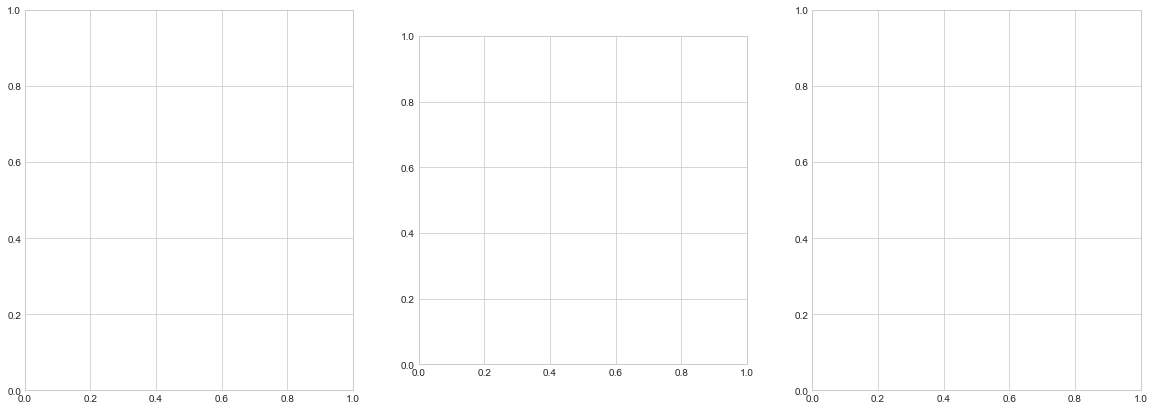

In [14]:
from tracker import Tracker
model = Tracker()
#sim = DynamicSimulation(model)
sim = NuscenesSimulation(model)
sim.run(N=2)

In [ ]:
from tracker import Tracker
model = Tracker()
sim = NuscenesSimulation(model)
sim.run(N=20)